[Text classification with preprocessed text: Movie reviews
](https://www.tensorflow.org/tutorials/keras/text_classification)

In [24]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

from matplotlib import pyplot as plt

print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.0.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [6]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset imdb_reviews downloaded and prepared to /home/tsunderex/tensorflow_datasets/imdb_reviews/subwords8k/0.1.0. Subsequent calls will reuse this data.


In [8]:
encoder = info.features['text'].encoder
print(f"Vocabulary size: {encoder.vocab_size}")

Vocabulary size: 8185


Test the encoder

In [9]:
sample_string = "Hello TensorFlow."

encoded_string = encoder.encode(sample_string)
print(f"Encoded string is {encoded_string}")

original_string = encoder.decode(encoded_string)
print(f"The original string: {original_string}")

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: Hello TensorFlow.


In [10]:
for ts in encoded_string:
    print(f"{ts} ----> {encoder.decode([ts])}")

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [13]:
for train_example, train_label in train_data.take(1):
    print(f"Encoded text: {train_example[:10].numpy()}")
    print(f"Label: {train_label.numpy()}")

Encoded text: [  12  284   14   32   25 1975   49 7079   28   73]
Label: 1


In [14]:
encoder.decode(train_example)

"I saw this film on True Movies (which automatically made me sceptical) but actually - it was good. Why? Not because of the amazing plot twists or breathtaking dialogue (of which there is little) but because actually, despite what people say I thought the film was accurate in it's depiction of teenagers dealing with pregnancy.<br /><br />It's NOT Dawson's Creek, they're not graceful, cool witty characters who breeze through sexuality with effortless knowledge. They're kids and they act like kids would. <br /><br />They're blunt, awkward and annoyingly confused about everything. Yes, this could be by accident and they could just be bad actors but I don't think so. Dermot Mulroney gives (when not trying to be cool) a very believable performance and I loved him for it. Patricia Arquette IS whiny and annoying, but she was pregnant and a teenagers? The combination of the two isn't exactly lavender on your pillow. The plot was VERY predictable and but so what? I believed them, his stress and

In [16]:
BUFFER_SIZE = 1000
train_batches = train_data.shuffle(BUFFER_SIZE).padded_batch(32, train_data.output_shapes)
test_batches = test_data.padded_batch(32, train_data.output_shapes)

In [17]:
for example_batch, label_batch in train_batches.take(2):
    print(f"Batch shape: {example_batch.shape}")
    print(f"label shape: {label_batch.shape}")

Batch shape: (32, 790)
label shape: (32,)
Batch shape: (32, 1371)
label shape: (32,)


In [19]:
model = Sequential([
    Embedding(encoder.vocab_size, 16),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 7s 9ms/step - loss: 0.6808 - accuracy: 0.6274 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 5s 6ms/step - loss: 0.6184 - accuracy: 0.7580 - val_loss: 0.5904 - val_accuracy: 0.7896
Epoch 3/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5383 - accuracy: 0.8117 - val_loss: 0.5270 - val_accuracy: 0.8104
Epoch 4/10
782/782 [==============================] - 5s 6ms/step - loss: 0.4708 - accuracy: 0.8433 - val_loss: 0.4732 - val_accuracy: 0.8479
Epoch 5/10
782/782 [==============================] - 5s 7ms/step - loss: 0.4192 - accuracy: 0.8645 - val_loss: 0.4340 - val_accuracy: 0.8573
Epoch 6/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3791 - accuracy: 0.8790 - val_loss: 0.3999 - val_accuracy: 0.8646
Epoch 7/10
782/782 [==============================] - 5s 6ms/step - loss: 0.3466 - accuracy: 0.8870 - val_loss: 0.3800 - val_accuracy: 0.861

In [22]:
loss, accuracy = model.evaluate(test_batches)
print(f"Loss: {loss:.4f}\n"
      f"Accuracy: {accuracy:.2%}")

782/782 [==============================] - 3s 4ms/step - loss: 0.3333 - accuracy: 0.8734
Loss: 0.3333
Accuracy: 87.34%


In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

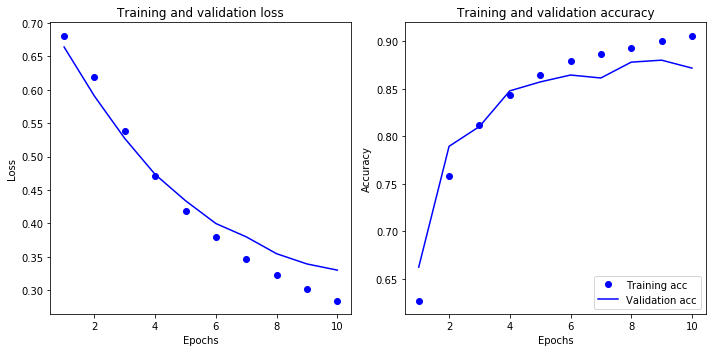

In [28]:
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, history_dict['loss'], 'bo', label='Training loss')
plt.plot(epochs, history_dict['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=4)
plt.tight_layout()